# Simple Random Forest Model with different number of estimators

Input: single PCA component from 15 indicators for 6 months

Output: optimal max-shape portfolio with loose restrictions for the next period

## Data Pre-processing

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from helper_functions import calculate_returns_for_model, calculate_metrics

In [16]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [17]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

In [18]:
days_to_recalculate = data_provider.get_days_to_recalculate()

# Start after 1 year to have enough historic data for first calculated period
days_to_recalculate = days_to_recalculate.iloc[12:]
days_to_recalculate = pd.DatetimeIndex(days_to_recalculate)
days_to_recalculate

DatetimeIndex(['2000-01-04', '2000-02-04', '2000-03-06', '2000-04-04',
               '2000-05-04', '2000-06-06', '2000-07-05', '2000-08-04',
               '2000-09-06', '2000-10-04',
               ...
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
               '2023-11-03', '2023-12-05'],
              dtype='datetime64[ns]', name='Days to rebalance', length=288, freq=None)

In [19]:
all_indicators = data_provider.key_indicators + data_provider.additional_indicators

x = []
for date in days_to_recalculate:
    indicators = data_provider.calculate_principal_component_from_indicators(
        date, periods=8, indicators=all_indicators)
    x.append(indicators.values)

x = np.array(x)
x.shape

(288, 8, 27)

In [20]:
os.chdir(os.path.expanduser('../optimization'))

from PortfolioOptimizer import PortfolioOptimizer

In [21]:
y = []
for i in range(0,len(days_to_recalculate)):
    if i == len(days_to_recalculate) - 1:
        data_period = df_countries.loc[
            days_to_recalculate[i]:]
    else:
        data_period = df_countries.loc[
            days_to_recalculate[i]:days_to_recalculate[i+1]]
    i += 1

    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_loose_constraints(acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except:        
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
        print('Cannot get optimal portfolio for', days_to_recalculate[i])

    y.append(optimal_portfolio.values)

y = np.array(y)
y.shape

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2022-08-03 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Cannot get optimal portfolio for 2023-05-04 00:00:00
Cannot get optimal portfolio for 2023-07-06 00:00:00
Cannot get optimal portfolio for 2023-12-05 00:00:00


c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


(288, 27)

In [22]:
test_split = int(0.8 * y.shape[0])

# Train
dates_for_training = days_to_recalculate[:test_split]
x_train = x[:test_split]
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = y[:test_split]

# Test
dates_for_test = days_to_recalculate[test_split:]
x_test = x[test_split:]
x_test = x_test.reshape(x_test.shape[0], -1)
y_test = y[test_split:]

In [23]:
os.chdir(os.path.expanduser('../data'))

In [24]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [25]:
selected_countries = df_countries.columns
days_to_rebalance = dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

## Defining models for different number of months

In [26]:
total_ret_list = []
cum_total_ret_list = []

for i in range(20):
    no_estimators = (i+1)*5
    print(f'Random Forest Model with {no_estimators} estimators')

    regressor_random_forest = RandomForestRegressor(n_estimators=no_estimators,
                                                    random_state=42)
    regressor_random_forest.fit(x_train, y_train)

    (total_ret, cum_total_ret) = calculate_returns_for_model(
        regressor_random_forest, x_test, dates_for_test,
        df_returns_test, selected_countries)

    total_ret_list.append(total_ret)
    cum_total_ret_list.append(cum_total_ret)

Random Forest Model with 5 estimators
Random Forest Model with 10 estimators
Random Forest Model with 15 estimators
Random Forest Model with 20 estimators
Random Forest Model with 25 estimators
Random Forest Model with 30 estimators
Random Forest Model with 35 estimators
Random Forest Model with 40 estimators
Random Forest Model with 45 estimators
Random Forest Model with 50 estimators
Random Forest Model with 55 estimators
Random Forest Model with 60 estimators
Random Forest Model with 65 estimators
Random Forest Model with 70 estimators
Random Forest Model with 75 estimators
Random Forest Model with 80 estimators
Random Forest Model with 85 estimators
Random Forest Model with 90 estimators
Random Forest Model with 95 estimators
Random Forest Model with 100 estimators


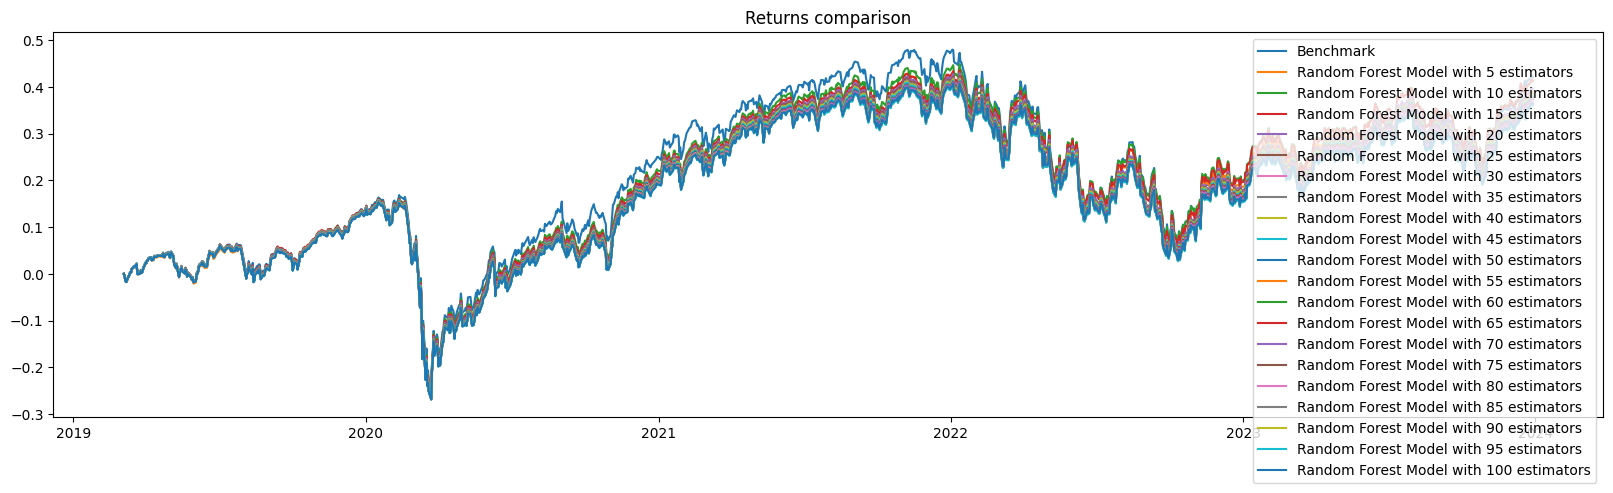

In [27]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')

for i in range(20):
    no_estimators = (i+1)*5
    plt.plot(cum_total_ret_list[i],
             label=f'Random Forest Model with {no_estimators} estimators')

plt.legend()
plt.title('Returns comparison')
plt.show()

In [28]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')

for i in range(20):
    no_estimators = (i+1)*5
    calculate_metrics(total_ret_list[i], df_results,
                      f'Random Forest Model with {no_estimators} estimators',
                      benchmark_returns)

df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Random Forest Model with 5 estimators,0.070741,0.199352,0.354854,0.41605,-0.355998,493.0,0.198711,-0.219587
Random Forest Model with 10 estimators,0.074441,0.199592,0.372965,0.436607,-0.356952,493.0,0.208545,-0.101921
Random Forest Model with 15 estimators,0.07457,0.199672,0.373464,0.436844,-0.358631,493.0,0.20793,-0.093875
Random Forest Model with 20 estimators,0.071603,0.199976,0.35806,0.417826,-0.36052,493.0,0.198612,-0.190978
Random Forest Model with 25 estimators,0.070108,0.200534,0.349606,0.40652,-0.36353,493.0,0.192854,-0.236513
Random Forest Model with 30 estimators,0.069146,0.200842,0.344282,0.400481,-0.364802,493.0,0.189545,-0.26381
Random Forest Model with 35 estimators,0.069692,0.201104,0.346549,0.402978,-0.365508,493.0,0.190672,-0.246191
Random Forest Model with 40 estimators,0.069736,0.200998,0.346948,0.403788,-0.365031,493.0,0.191041,-0.245546
Random Forest Model with 45 estimators,0.069115,0.20113,0.343634,0.399657,-0.36539,493.0,0.189154,-0.265097
